In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import linregress
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw

In [33]:
path = "./examples/series_01.csv"
df = pd.read_csv(path)
df.shape[0]
#df.head()

816

In [9]:
def draw_localizations(
    df,
    image,
    orig_size=(2560, 2560),
    pixel_size_original_nm=16.0,
    radius=2,
    color="red"
):
    """
    Draw ThunderSTORM localizations on an image.

    Parameters:
        df : pandas DataFrame with columns ["x [nm]", "y [nm]"]
        image : PIL Image OR path to image
        orig_size : tuple (orig_w, orig_h) of image used for localization
        pixel_size_original_nm : float, nm per pixel in original image
        radius : int, radius of drawn dots
        color : color of dots

    Returns:
        PIL Image with points drawn
    """

    # If image is a path, open it
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")
    else:
        image = image.convert("RGB")

    draw = ImageDraw.Draw(image)

    jpg_w, jpg_h = image.size
    orig_w, orig_h = orig_size

    # scaling from original px -> current image px
    sx = jpg_w / orig_w
    sy = jpg_h / orig_h

    for _, row in df.iterrows():
        x_nm = row["x [nm]"]
        y_nm = row["y [nm]"]

        # nm -> original pixels
        x_orig_px = x_nm / pixel_size_original_nm
        y_orig_px = y_nm / pixel_size_original_nm

        # original pixels -> current image pixels
        x_px = int(round(x_orig_px * sx))
        y_px = int(round(y_orig_px * sy))

        if 0 <= x_px < jpg_w and 0 <= y_px < jpg_h:
            draw.ellipse(
                (x_px - radius, y_px - radius,
                 x_px + radius, y_px + radius),
                fill=color
            )

    return image


11


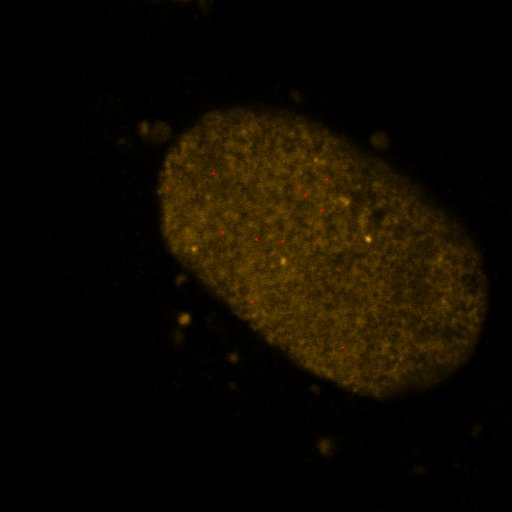

In [ ]:
# Filter out localizations with large sigma
df_fileterd = df[(df["sigma [nm]"] < 200) & (df["intensity [photon]"] > 10000)]
print(df_fileterd.shape[0])

# Plotting
result = draw_localizations(
    df_fileterd,
    "./examples/series_01.jpg",
    orig_size=(2560, 2560),
    pixel_size_original_nm=16,
    radius=1,
    color="red"
)

result.show()

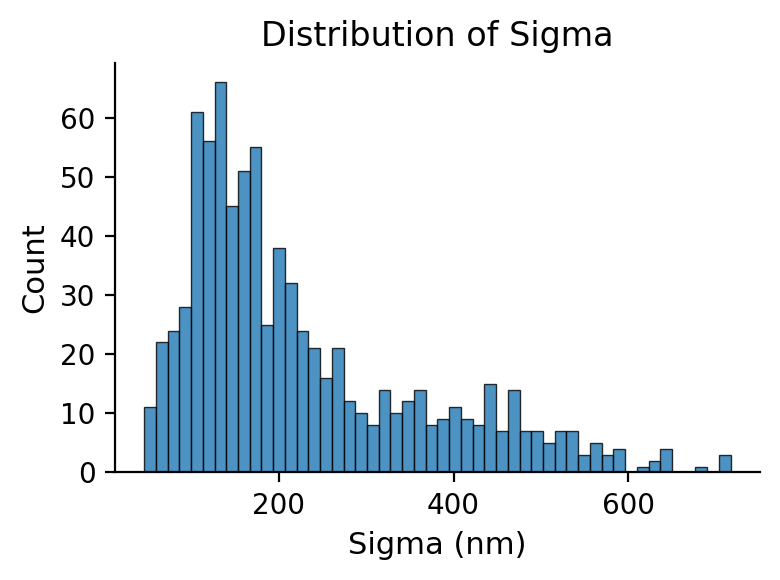

In [40]:
plt.figure(figsize=(4, 3), dpi=200)

plt.hist(
    df["sigma [nm]"],
    bins=50,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.8
)

plt.xlabel("Sigma (nm)", fontsize=11)
plt.ylabel("Count", fontsize=11)
plt.title("Distribution of Sigma", fontsize=12)

# Remove top/right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


Cluster centers: [np.float64(159.07190661264175), np.float64(436.96237502512554)]
Threshold: 298.01714081888366


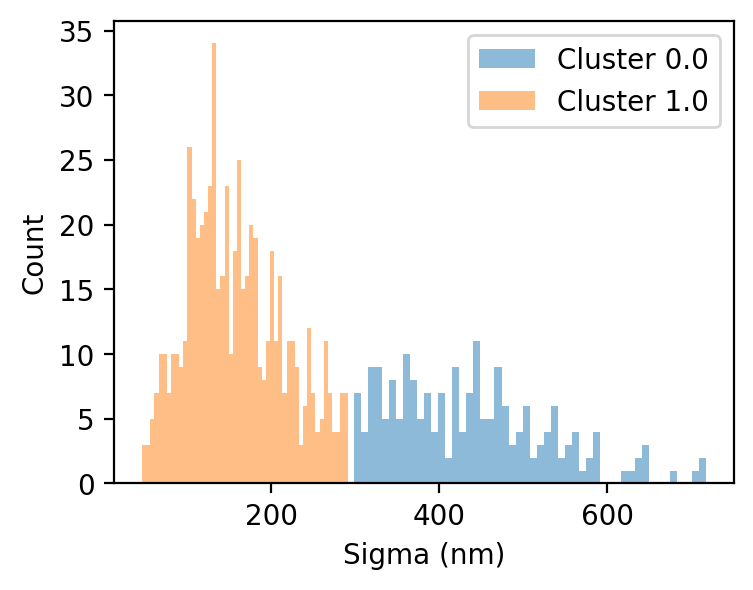

In [41]:
X = df[["sigma [nm]"]]   # must stay 2D for sklearn
X = df[["sigma [nm]"]].dropna()

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)
df.loc[X.index, "cluster"] = labels

# Threshold
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)

print("Cluster centers:", centers)
print("Threshold:", threshold)

# plot
plt.figure(figsize=(4,3), dpi=200)

for cluster in sorted(df["cluster"].dropna().unique()):
    subset = df[df["cluster"] == cluster]
    plt.hist(subset["sigma [nm]"], bins=50, alpha=0.5, label=f"Cluster {cluster}")

plt.xlabel("Sigma (nm)")
plt.ylabel("Count")
plt.legend()

plt.show()



In [42]:
def scatter_plot(df, x_col, y_col):
    plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(df[x_col], df[y_col], alpha=0.6)
    
    plt.xlabel(x_col.replace("_", " "))
    plt.ylabel(y_col.replace("_", " "))
    
    plt.tight_layout()
    plt.show()

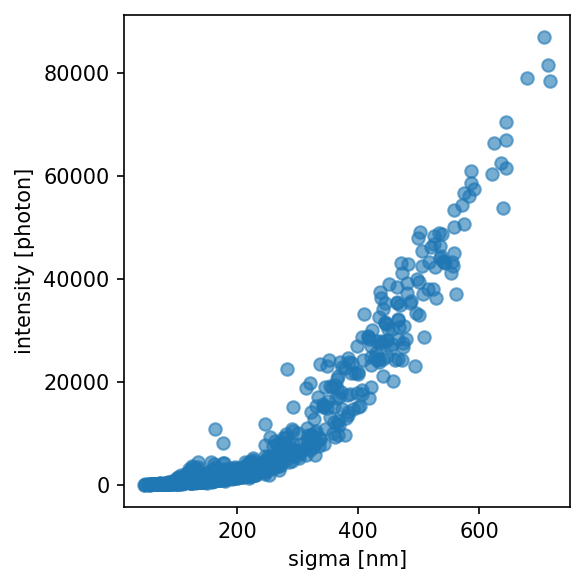

In [17]:
scatter_plot(df, "sigma [nm]", "intensity [photon]")

Task:
1. sigma - 2 populations (KMeans)
2. Outliers of sigma - check them:
 - big bright dots: analyze as a third population
 - aggregates: analyze separatly
 - MFI of nucleus - big dots/aggregates
3. How the bg susbstruction affects the sigma, MFI of foci?

In [ ]:
means = df.groupby("sigma [nm]")["intensity [photon]"].mean()
plt.bar(means.index, means.values)
plt.xlabel("sigma [nm]")
plt.ylabel("Mean intensity [photon]")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Select two columns
n_clusters = 2
X = df[["sigma [nm]", "intensity [photon]"]].dropna()

# Run clustering (choose number of clusters)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_
sigma_centers = centers[:, 0]
intensity_centers = centers[:, 1]
print("Cluster centers (sigma [nm], intensity [photon]):")
for i in range(len(sigma_centers)):
    print(f"Cluster {i}: ({sigma_centers[i]:.2f}, {intensity_centers[i]:.2f})")

# Plot result
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels)
plt.xlabel("sigma [nm]")
plt.ylabel("intensity [photon]")
plt.show()

In [ ]:
df_bright = df[df["sigma [nm]"] > 400]
df_medium = df[(df["sigma [nm]"] > 150) & (df["sigma [nm]"] <= 400)]
df_dark = df[df["sigma [nm]"] <= 150]

print("Bright foci count:", df_bright.shape[0])
print("Medium foci count:", df_medium.shape[0])
print("Dark foci count:", df_dark.shape[0])

In [ ]:
df1 = df[df["sigma [nm]"] > 500]
print("Bright foci count:", df1.shape[0])